In [1]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 4.2 MB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.6 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 21.4 MB/s 
     |████████████████████████████████| 346 kB 7.7 MB/s 
     |████████████████████████████████| 212 kB 52.5 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 140 kB 58.1 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 127 kB 62.3 MB/s 
     |████████████████████████████████| 144 kB 35.1 MB/s 
     |████████████████████████████████| 271 kB 54.5 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 112 kB 73.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 re

# Part 0 - Imports and datasets loading

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datasets import load_dataset, load_metric
from transformers import pipeline, AutoTokenizer,  AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm #used for progress bar





import math
import spacy
import random
random.seed(1)
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = load_dataset('emotion')

print (dataset.column_names)
print (len(dataset['train']), len(dataset['validation']), len(dataset['test']))

#labels in this dataset
emotions=['sadness','joy','love','anger','fear','surprise']
reverse_emotions = {emotions[i]:i for i in range(len(emotions))}

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}
16000 2000 2000


Part 1 - Perform EDA on the dataset.

Try answering questions like - 
* What is the distribution of labels in the dataset?
* What is the distribution of the length of the texts?
* What is the distribution of words per class? (you can use the wordcloud dataset for visualization)

Lets start with taking a glimpse on each of the sets:

In [5]:
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

In [6]:
# Lets take a look on a sample of each of the sets
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
val_df.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


In [8]:
test_df.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


Dataset sizes and empty values:

In [9]:
def dataset_overview(dataset_name, df):
  print(f"\n### Overview for {dataset_name} dataset ###")
  print(f"Dataset columns: {df.columns.tolist()}")
  print(f"Dataset shape: {df.shape}")
  print(f"Null values in data:{df.isnull().values.any()}")
  print(f"Dataset Description:\n{df.describe()}\n")
  print("Dataset info:")
  df.info(show_counts=True)
  

In [10]:
dataset_overview('train', train_df)
dataset_overview('validation', val_df)
dataset_overview('test', test_df)


### Overview for train dataset ###
Dataset columns: ['text', 'label']
Dataset shape: (16000, 2)
Null values in data:False
Dataset Description:
              label
count  16000.000000
mean       1.565937
std        1.501430
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB

### Overview for validation dataset ###
Dataset columns: ['text', 'label']
Dataset shape: (2000, 2)
Null values in data:False
Dataset Description:
             label
count  2000.000000
mean      1.569000
std       1.480991
min       0.000000
25%       0.000000
50%       1.000000
75%       3.000000
max       5.000000

Dataset info:
<class 'pandas.core.fra

In [11]:
# Looking for text duplicates -
train_df.text.value_counts()

i feel on the verge of tears from weariness i look at your sweet face and cant help but tenderly kiss your cheeks                                                                          2
i feel kind of strange                                                                                                                                                                     2
i feel more adventurous willing to take risks img src http cdn                                                                                                                             2
i write these words i feel sweet baby kicks from within and my memory is refreshed i would do anything for this boy                                                                        2
i still feel a craving for sweet food                                                                                                                                                      2
                                                       

In [12]:
val_df.text.value_counts()

i feel so tortured by it                                                                                                                                                                                                                                                        2
i have had several new members tell me how comfortable they feel with how accepted they are by the existing members and that is great to hear                                                                                                                                   2
im feeling quite sad and sorry for myself but ill snap out of it soon                                                                                                                                                                                                           1
i just sank into feeling completely satisfied by the time it was done and oh the sex was super excellent because they had both been dying to get at each other so it had an edge o

In [13]:
test_df.text.value_counts()

im feeling rather rotten so im not very ambitious right now                                                                                                                                                                                            1
i feel as though were giving too many details about unimportant things like chriss mundane life and left out on other details like more character depth especially with secondary characters                                                           1
im feeling my way often blindly from the carefree days of youth into the uncharted waters of maturity aka the midlife crisis here i explore transformation via one of my favorite things the tracy anderson method                                     1
im feeling so embarrassed frightened that i wouldve smashed the window and slid in dukes of hazzard style if it would get garage man to stop glaring at me                                                                                             1
i co

In [14]:
for text in train_df.text.tolist():
  if text in val_df.text.tolist():
    print(f"Potential text leakage from train -> validation: '{text}'")
  if text in test_df.text.tolist():
    print(f"Potential text leakage from train -> test: '{text}'")

Potential text leakage from train -> test: 'i feel like some of you have pains and you cannot imagine becoming passionate about the group or the idea that is causing pain'
Potential text leakage from train -> validation: 'i feel completely blessed to be a part of this group'
Potential text leakage from train -> test: 'i loved the feeling i got during an amazing slalom run whether it was in training or in a race'
Potential text leakage from train -> test: 'i feel cared for and accepted'
Potential text leakage from train -> validation: 'i honestly feel at heart we should be faithful to each other if its yo girl'
Potential text leakage from train -> validation: 'i feel that being faithful isnt enough in your eyes'
Potential text leakage from train -> test: 'i feel so weird and scattered with all wonders about a million different things'
Potential text leakage from train -> test: 'i have not conducted a survey but it is quite likely that many of them feel as assaulted by onel s demons and 

Seems like both train and validation have duplicates in them, if it was a production project I would have dropped the duplicates (we are effectively giving duplicate weight to these samples).

In addition, there are sentences that appear in our training set and also exist in the test and validation sets, this is a red flag and it shouldn't happen, if it wasn't a task on a given dataset I would have dropped these samples from our training set.

##### Labels

According to the dataset docs:

The label classes are:
sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

Let's review the distribution per class per set, in general and in specific aspects like text length for example

In [15]:
def labels_dist(ds_name, df):
  print(f"### Labels stats for {ds_name} dataset ###")
  normalized_ds_counts = df.label.value_counts(normalize=True) * 100
  print(f"Label counts:\n{df.label.value_counts()}")
  print(f"Label percentages:\n{normalized_ds_counts}")
  ax = sns.barplot(x=normalized_ds_counts.index, y=normalized_ds_counts)
  plt.show()

### Labels stats for train dataset ###
Label counts:
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64
Label percentages:
1    33.51250
0    29.16250
3    13.49375
4    12.10625
2     8.15000
5     3.57500
Name: label, dtype: float64


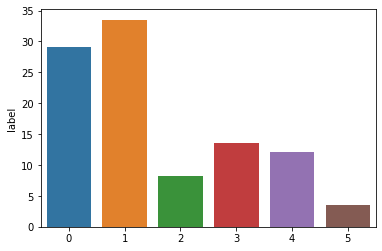

In [16]:
labels_dist('train', train_df)

### Labels stats for validation dataset ###
Label counts:
1    704
0    550
3    275
4    212
2    178
5     81
Name: label, dtype: int64
Label percentages:
1    35.20
0    27.50
3    13.75
4    10.60
2     8.90
5     4.05
Name: label, dtype: float64


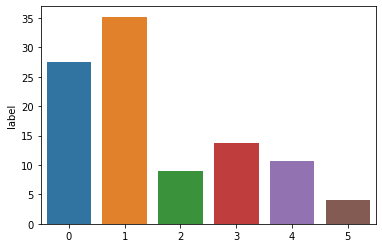

In [17]:
labels_dist('validation', val_df)

### Labels stats for test dataset ###
Label counts:
1    695
0    581
3    275
4    224
2    159
5     66
Name: label, dtype: int64
Label percentages:
1    34.75
0    29.05
3    13.75
4    11.20
2     7.95
5     3.30
Name: label, dtype: float64


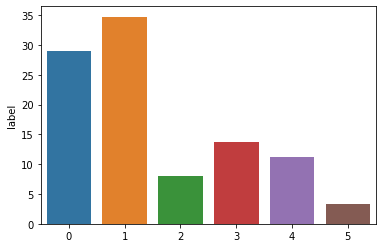

In [18]:
# Although it is not common to check the test labels (as it can cause bias and leakage in our decisions), I wanted to verify there isn't any really odd change in the distribution 
# This can indicate sometimes a bad split method / splitting in a non-random manner which can change the "real" labels distribution
labels_dist('test', test_df)

1. We can see that about 60%-65% of the samples are split between saddness(0) and joy(1)
2. love (2) and surprise(5) barely have representation in out different sets.

##### Text lengths exploration

In [19]:
def get_text_length_stats(ds_name, df):
  print(f"### Analysis for text lengths in {ds_name} dataset ###")
  df['text_length'] = df.text.map(lambda x: len(x))
  print(df.text_length.describe())

  print("\nGeneric text length distribution:")
  sns.histplot(df.text_length)
  plt.show()

  print("\n## Distributions per label")
  for label in range(6):
    print(f"Label - {label}")
    partial_df = df[df.label==label]
    sns.histplot(partial_df.text_length)
    plt.show()
    print("")
  
  print("")


### Analysis for text lengths in train dataset ###
count    16000.000000
mean        96.845812
std         55.904953
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text_length, dtype: float64

Generic text length distribution:


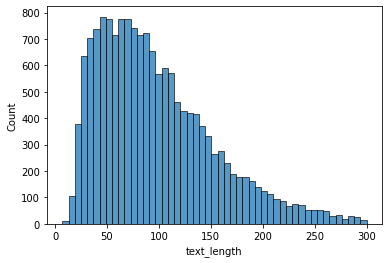


## Distributions per label
Label - 0


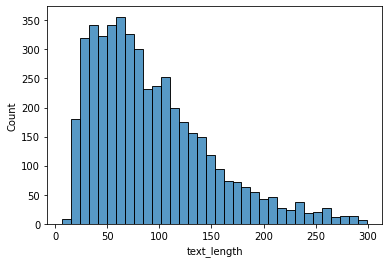


Label - 1


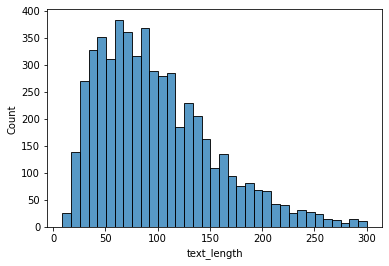


Label - 2


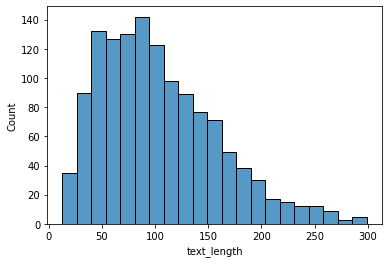


Label - 3


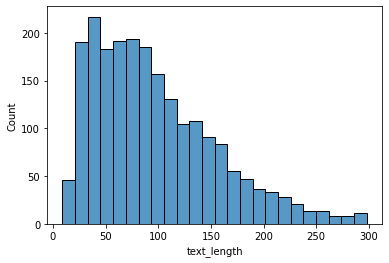


Label - 4


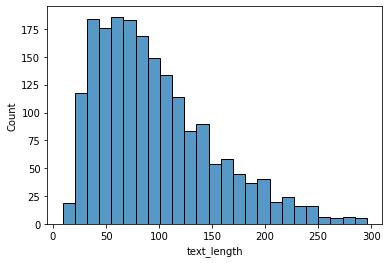


Label - 5


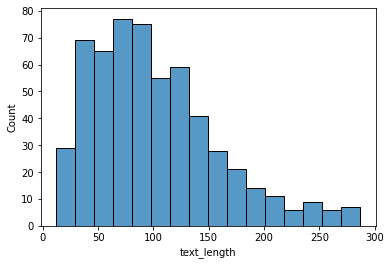

In [20]:
get_text_length_stats('train', train_df)

##### Text words exploration

In [21]:
# Loading stop words
sp = spacy.load('en_core_web_sm')
STOP_WORDS = sp.Defaults.stop_words

In [22]:
df = train_df.copy()

# create a list of emotions
emotions = df.label.unique()
#create a list of responses for each emotion using a list comprehension
corpus = [' '.join(df[(df.label==emotion)].text.tolist()) for emotion in emotions]

#instantiate a CountVectorizer object
cv=CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 3))

# fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=emotions

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
#build an empty dataframe
t_bow_df=pd.DataFrame()

# By emotion, divide the number of times a word is said, 
# by the total number of times they were said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for emotion in tqdm(emotions):
    feat_s = bow[bow.index != emotion].sum()+1 #sum all the times each word was said excluding the emotion
    feat_s_all = np.sum(bow[bow.index != emotion].sum()) # all the total words that were said, excluding the emotion
    tot = feat_s / feat_s_all #find the frequency of words said among other emotions
    row = bow_transformed.loc[emotion] / tot #divide the emotion's array of frequency of words by all other emotions' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[emotion])]) #append to df

100%|██████████| 6/6 [01:01<00:00, 10.32s/it]



WordCloud for emotion - (0, 'Sadness')


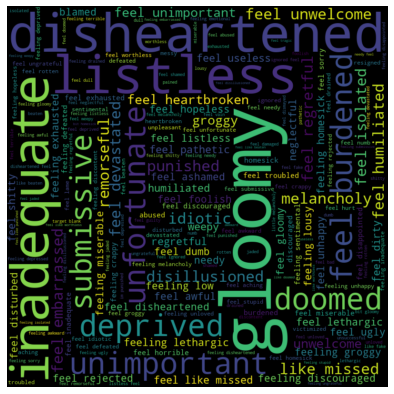


WordCloud for emotion - (1, 'Joy')


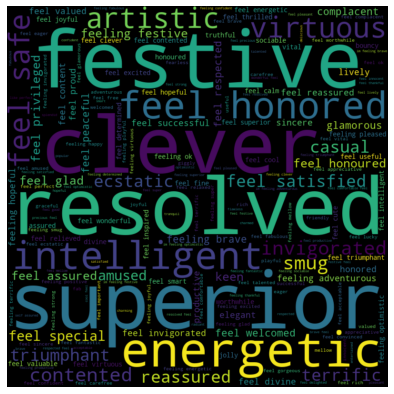


WordCloud for emotion - (2, 'Love')


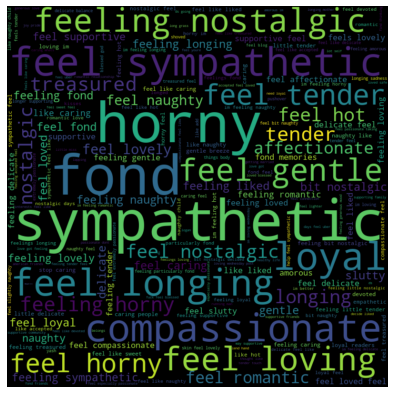


WordCloud for emotion - (3, 'Anger')


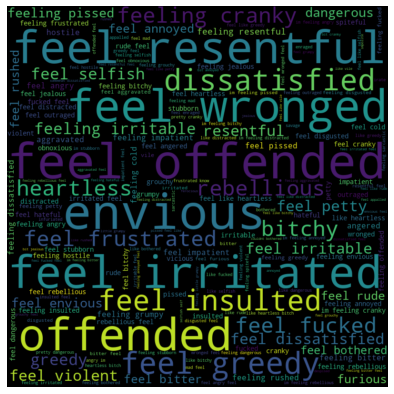


WordCloud for emotion - (4, 'Fear')


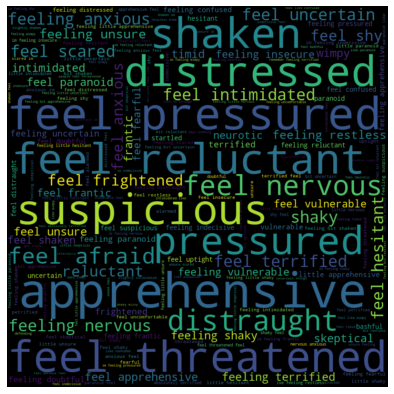


WordCloud for emotion - (5, 'Surprise')


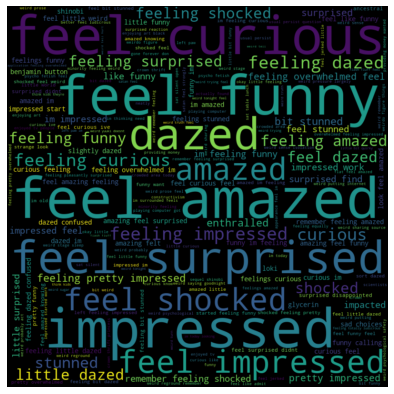

In [24]:
label_to_emotion = {0: 'Sadness',
                    1: 'Joy',
                    2: 'Love',
                    3: 'Anger',
                    4: 'Fear',
                    5: 'Surprise'}

for label in label_to_emotion.keys(): 

  print(f"\nWordCloud for emotion - {(label, label_to_emotion.get(label))}")
  # create the WordCloud object
  wordcloud = WordCloud(background_color='black', height=800, width=800)

  text=t_bow_df.loc[label].sort_values(ascending=False)[:400]
  # create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
  text_dict=t_bow_df.loc[label].sort_values(ascending=False).to_dict()

  # generate the word cloud
  wordcloud.generate_from_frequencies(text_dict)

  #plot
  plt.figure(figsize=(7,7))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# Part 2 - Finetune a LM on the emotions dataset

In this section you are required to fine tune a LM using the transformers package on the emotions dataset, for refernce you may assist with Hugging Face's notebooks.

##### Preprocessing

In [25]:
dataset_name = "emotion"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

dataset = load_dataset(dataset_name)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [26]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [27]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [28]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Loading pretrained model + Fine-tuning

In [29]:
num_labels = len(train_df.label.unique().tolist())
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [30]:
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-emotion",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name
)

In [31]:
def acc_and_f1(preds, labels):
    acc = (preds == labels).mean().item()
    f1_macro = f1_score(y_true=labels, y_pred=preds, average='macro').item()
    f1_micro = f1_score(y_true=labels, y_pred=preds, average='micro').item()
    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
    }

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return acc_and_f1(preds=predictions, labels=labels)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,0.258000,0.202152,0.923500,0.892694,0.923500
2,0.156400,0.152167,0.938000,0.910527,0.938000
3,0.116300,0.183336,0.933500,0.906668,0.933500
4,0.078500,0.185876,0.940000,0.912434,0.940000
5,0.061200,0.188655,0.943000,0.917772,0.943000


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-emotion/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-emotion/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If

TrainOutput(global_step=5000, training_loss=0.17806348114013673, metrics={'train_runtime': 353.3561, 'train_samples_per_second': 226.4, 'train_steps_per_second': 14.15, 'total_flos': 973406760832512.0, 'train_loss': 0.17806348114013673, 'epoch': 5.0})

In [33]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.943,
 'eval_f1_macro': 0.9177723885777471,
 'eval_f1_micro': 0.943,
 'eval_loss': 0.18865515291690826,
 'eval_runtime': 1.9945,
 'eval_samples_per_second': 1002.774,
 'eval_steps_per_second': 62.673}

# Part 3 - zero-shot classification using prompts

It turns out that prompting can be used not only on huge LM but also on small/medium-sized LM. The idea is fairly simple and it utilizes the masked language loss that the model was trained on. The process goes like this: 

Assume that we have a sentiment analysis task in hand. To classify the following sentence:

* I didn't enjoy the movie at all.

We will modify the input sentence with a prompt:

* I didn't enjoy the movie at all. The movie was \<MASK\>

The modified sentence will be used as an input for the model. The model (which was trained to complete masked words) will output candidates for the masked word. 

* terrible

Now, how can we use that word?

We will have to keep a mapping that will translate the word "terrible" to one of our labels in this case negative


In this part, you are required to implement the above method and compare it to the fully fine-tuned model from part 1



In [40]:
# Let's create a base class wrapping a LM for promting

from transformers import AutoModelForMaskedLM , AutoTokenizer
import torch

class Prompting(object):
  """ doc string 
   This class helps us to implement
   Prompt-based Learning Model
  """
  def __init__(self, **kwargs):
    """ constructor 
    parameter:
    ----------
       model: AutoModelForMaskedLM
            path to a Pre-trained language model form HuggingFace Hub
       tokenizer: AutoTokenizer
            path to tokenizer if different tokenizer is used, 
            otherwise leave it empty
    """
    model_path=kwargs['model']
    tokenizer_path= kwargs['model']
    if "tokenizer" in kwargs.keys():
      tokenizer_path= kwargs['tokenizer']
    self.model = AutoModelForMaskedLM.from_pretrained(model_path)
    self.tokenizer = AutoTokenizer.from_pretrained(model_path)

  def prompt_pred(self, text):
    """
      Predict MASK token by listing the probability of candidate tokens 
      where the first token is the most likely
      Parameters:
      ----------
      text: str 
          The text including [MASK] token.
          It supports single MASK token. If more [MASK]ed tokens 
          are given, it takes the first one.
      Returns:
      --------
      list of (token, prob)
         The return is a list of all token in LM Vocab along with 
         their prob score, sort by score in descending order 
    """
    indexed_tokens=self.tokenizer(text, return_tensors="pt").input_ids
    tokenized_text= self.tokenizer.convert_ids_to_tokens (indexed_tokens[0])
    # take the first masked token
    mask_pos=tokenized_text.index(self.tokenizer.mask_token)
    self.model.eval()
    with torch.no_grad():
      outputs = self.model(indexed_tokens)
      predictions = outputs[0]
    values, indices=torch.sort(predictions[0, mask_pos],  descending=True)
    #values=torch.nn.functional.softmax(values, dim=0)
    result=list(zip(self.tokenizer.convert_ids_to_tokens(indices), values))
    self.scores_dict={a:b for a,b in result}
    return result

  def compute_tokens_prob(self, text, tokens_dict):
    """
    Compute the activations for a given token dict (key - token category, value - list of optional tokens)
    """
    _=self.prompt_pred(text)
    scores = []
    
    for key, tokens in tokens_dict.items():
      score=[self.scores_dict[token] if token in self.scores_dict.keys() else 0\
              for token in tokens]
      score= sum(score)
      scores.append((key, score))  

    softmax_rt=torch.nn.functional.softmax(torch.Tensor([s[1] for s in scores]), dim=0)
    keys = [s[0] for s in scores]
    return keys, softmax_rt

In [41]:
model_path = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)
prompting= Prompting(model=model_path)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

In [42]:
# Let's look on a couple of prompted words
prompt=" I feel [MASK]."

for txt in train_df.head(10).text.tolist():
  modified_txt = txt + prompt
  print(f"Message with prompt: {modified_txt}")
  print(f"Top 3 promted tokens: {prompting.prompt_pred(modified_txt)[:3]}\n")

Message with prompt: i didnt feel humiliated I feel [MASK].
Top 3 promted tokens: [('guilty', tensor(8.5898)), ('embarrassed', tensor(8.1144)), ('angry', tensor(7.5845))]

Message with prompt: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake I feel [MASK].
Top 3 promted tokens: [('alive', tensor(8.2183)), ('happy', tensor(7.3950)), ('safe', tensor(7.3518))]

Message with prompt: im grabbing a minute to post i feel greedy wrong I feel [MASK].
Top 3 promted tokens: [('wrong', tensor(7.6300)), ('sick', tensor(7.4872)), ('stupid', tensor(7.2848))]

Message with prompt: i am ever feeling nostalgic about the fireplace i will know that it is still on the property I feel [MASK].
Top 3 promted tokens: [('safe', tensor(9.2804)), ('grateful', tensor(8.3005)), ('lonely', tensor(8.2517))]

Message with prompt: i am feeling grouchy I feel [MASK].
Top 3 promted tokens: [('sick', tensor(9.9827)), ('tired', tensor(8.9033)), ('stupid', tensor(8

In [70]:
# Let's create the predicted token -> label mapping based on the training set
predicted_word_to_sentiment_mapping = dict()

# I only use the first 2000 rows as bert inference time was too long here with my local hardware setup
for idx, values in train_df[:2000].iterrows():
  modified_txt = values.text + prompt
  predicted_word = prompting.prompt_pred(modified_txt)[0][0]
  if not predicted_word_to_sentiment_mapping.get(predicted_word):
    predicted_word_to_sentiment_mapping[predicted_word] = values.label

In [72]:
# Let's evaluate the model on the validation set

def predict_sentiment(raw_text):
  modified_txt = raw_text + prompt
  predicted_word = prompting.prompt_pred(modified_txt)[0][0] # Get the predicted token with highest probability
  if not predicted_word_to_sentiment_mapping.get(predicted_word):
    return 0 # set the most common label in case we did not predict a known word
  else:
    return predicted_word_to_sentiment_mapping.get(predicted_word)


preds_df = val_df.copy()
preds_df['model_prediction'] = preds_df.text.map(lambda x: predict_sentiment(x))

y_preds = np.array(preds_df.model_prediction)
y_label = np.array(val_df.label)

acc = (y_preds == y_label).mean().item()
f1_macro = f1_score(y_true=y_label, y_pred=y_preds, average='macro').item()
f1_micro = f1_score(y_true=y_label, y_pred=y_preds, average='micro').item()


print(f"Accuracy: {acc}")
print(f"F1 (micro): {f1_micro}")
print(f"F1 (macro): {f1_macro}")

Accuracy: 0.259
F1 (micro): 0.259
F1 (macro): 0.20297602981906213


Seems like this "naive" approach did not work so well, at least not better than our fine tune model that had the next results on the validation set:

'eval_accuracy': 0.943

'eval_f1_macro': 0.9177723885777471

'eval_f1_micro': 0.943

#Bonus 1

As you might noticed this is a vanilla approach on how we can utilize prompting to fine tune LM. There is a lot of room for improvment

Come up with idea\s on how you can improve the above method


Ideas - 


1. There is a problem with our approach as it requires using the predicted token and evaluating the sentiment it relates to, instead I will try to define a set of X words per sentiment and evaluate the probabilities for each token (each of the x words) - Then decide which sentiment had the highest probability out of the 6 categories we had.
2. prompt-based fine-tuning - The results can be improved by incorporating a few examples and fine tuning our model on them. We can fine-tune a LM with our examples.
3. We can apply semi-supervised training procedure, like PET.
4. We can modify our prompts to better match each sentence instead of using the same prompt, this will probably improve the results as well.

#Bonus 2

Implement one of your ideas

I will implement the 1st idea (evaluate the sentiment by predicting the probability of a specific sentiment)

In [66]:
# I've built this dict based on the word clouds we created earlier
label_tokens_dict = {0: ['sadness', 'sad', 'bad', 'depressed', 'gloomy'],
                     1: ['joy', 'festive', 'resolved', 'superior', 'energetic'],
                     2: ['love', 'horny', 'fond', 'sympathetic', 'loyal'],
                     3: ['angry', 'offended', 'envious', 'irritated', 'insulted'],
                     4: ['fear', 'precious', 'suspicious', 'distressed', 'threatened'],
                     5: ['surprise', 'amazed', 'surprised', 'funny', 'impressed']}

In [67]:
prompt=" I feel [MASK]."

for idx,values in train_df.head(10).iterrows():
  modified_txt = values.text + prompt
  print(f"Message with prompt: {modified_txt}")
  labels, softmax = prompting.compute_tokens_prob(modified_txt, tokens_dict=label_tokens_dict)
  predicted_sentiment = np.argmax(softmax)
  print(f"Evaluated sentiment results:\nSoftmax-{softmax}\nPredicted Sentiment-{predicted_sentiment}\nActual Label-{values.label}\n\n")

Message with prompt: i didnt feel humiliated I feel [MASK].
Evaluated sentiment results:\Softmax-tensor([5.1963e-02, 1.2404e-07, 1.4578e-07, 9.3002e-01, 5.7841e-03, 1.2234e-02])
Predicted Sentiment-3
Actual Label-0


Message with prompt: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake I feel [MASK].
Evaluated sentiment results:\Softmax-tensor([9.9763e-01, 1.6269e-04, 9.5113e-05, 1.6337e-07, 4.2247e-04, 1.6860e-03])
Predicted Sentiment-0
Actual Label-0


Message with prompt: im grabbing a minute to post i feel greedy wrong I feel [MASK].
Evaluated sentiment results:\Softmax-tensor([9.9477e-01, 1.0548e-07, 2.2161e-08, 4.1546e-03, 1.0571e-03, 2.2810e-05])
Predicted Sentiment-0
Actual Label-3


Message with prompt: i am ever feeling nostalgic about the fireplace i will know that it is still on the property I feel [MASK].
Evaluated sentiment results:\Softmax-tensor([4.6713e-01, 2.5584e-06, 4.9436e-01, 5.8532e-05, 3.0803e-02, 7.639

In [68]:
# Let's evaluate the model on the validation set
model_preds = []

for idx, values in val_df.iterrows():
  modified_txt = values.text + prompt
  
  labels, softmax = prompting.compute_tokens_prob(modified_txt, tokens_dict=label_tokens_dict)
  model_preds.append(np.argmax(softmax))

y_preds = np.array(model_preds)
y_label = np.array(val_df.label)

acc = (y_preds == y_label).mean().item()
f1_macro = f1_score(y_true=y_label, y_pred=y_preds, average='macro').item()
f1_micro = f1_score(y_true=y_label, y_pred=y_preds, average='micro').item()


print(f"Accuracy: {acc}")
print(f"F1 (micro): {f1_micro}")
print(f"F1 (macro): {f1_macro}")

Accuracy: 0.311
F1 (micro): 0.311
F1 (macro): 0.2098077618890601


Seems like the approach of computing multiple pre-defined tokens improved our model slightly (compared to the first zero-shot prompting model).

I believe that if we would have worked on smarter prompts that match the sentence and if we implement the additional ideas I suggested we can even get to better results and pherhabs surpass our fine-tuned model.